### Word Embeddings for Text Classification (Emotion Recognition)

**Task:** Classify text data into different emotions using word embedding and other deep information retrieval approaches.


**Dataset: ** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

---

### Requirements:

#### Software:
------------------

* Python 3 (coding will be done strictly using Python)
* Anaconda Environment (recommended but not mandatory) (https://www.continuum.io/downloads)
* Jupyter (http://jupyter.org/)
* Google's word2vec (Download the file... warning! it is really huge)(https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)
* Gensim (https://radimrehurek.com/gensim/)
* Scikit Learn (http://scikit-learn.org/stable/) (get the latest version)
* Pandas (http://pandas.pydata.org/)
* Matplotlib (https://matplotlib.org/)
* NLTK (for stopwords) (http://www.nltk.org/)

#### Computing Resources:
-------------------
* Operating System: Preferably Linux or MacOS (Windows break but you can try it out)
* RAM: 4GB 
* Disk Space: 8GB (mostly to store word embeddings)

---

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score, classification_report
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
from helpers import *

%matplotlib inline

### Data Exploration

In [4]:
### train data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
train_data = pd.concat([anger_train, fear_train, joy_train, sadness_train])

### test data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
test_data = pd.concat([anger_test, fear_test, joy_test, sadness_test])

In [5]:
anger_train.head(10)

id                                               text emotion  intensity
0  10000  How the fu*k! Who the heck! moved my fridge!.....   anger      0.938
1  10001  So my Indian Uber driver just called someone t...   anger      0.896
2  10002  @DPD_UK I asked for my parcel to be delivered ...   anger      0.896
3  10003  so ef whichever butt wipe pulled the fire alar...   anger      0.896
4  10004  Don't join @BTCare they put the phone down on ...   anger      0.896
5  10005                                My blood is boiling   anger      0.875
6  10006  When you've still got a whole season of Wentwo...   anger      0.875
7  10007  @bt_uk why does tracking show my equipment del...   anger      0.875
8  10008  @TeamShanny legit why i am so furious with him...   anger      0.875
9  10009  How is it suppose to work if you do that? Wtf ...   anger      0.875

In [6]:
# shuffle dataset
train_data = train_data.sample(frac=1)
test_data = test_data.sample(frac=1)

In [7]:
train_data.head(10)

id                                               text  emotion  \
581  20581  @drunkejt almost all of my mutuals intimidated...     fear   
91   30091  having a pet store worker ask 'do you want to ...      joy   
252  30252  .@Harry_Styles I hope you never go a day witho...      joy   
300  40300  @marksandspencer Where has your 50% grapefruit...  sadness   
808  10808  Sometimes the best motivations come from 'prov...    anger   
276  10276  @DanRather What King says doesn't matter. The ...    anger   
885  20885    the ending of how I met your mother is dreadful     fear   
250  10250  A @FirstBSA not turning up? Why am I not surpr...    anger   
492  40492  @littlebakaa @AlcohoIPorn give me a smiling em...  sadness   
767  40767  I added Paul Walker on Xbox but he just spends...  sadness   

     intensity  
581      0.479  
91       0.771  
252      0.600  
300      0.562  
808      0.250  
276      0.562  
885      0.333  
250      0.583  
492      0.417  
767      0.167

In [8]:
### Count the number of words in training dataset
train_data['text'].apply(lambda x: len(x.split(' '))).sum()

58792

**Note:** Usually at least 500K words are suggested to train a word2vec model, so performance may not be the best here.

**Exercise 1:** Plot word frequency in both train and test dataset. (Hint: refer to DM lab 1)

In [9]:
### classes / targets
my_tags = ['sadness', 'fear', 'joy', 'anger']

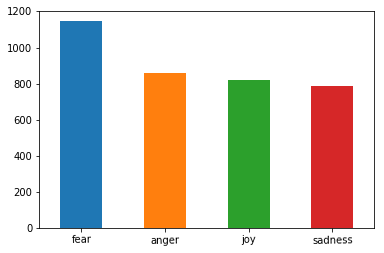

In [10]:
#plot the categories distribution for training data
train_data.emotion.value_counts().plot(kind='bar', rot=1)

**Exercise:** Is this considered an imbalanced dataset? Try to perform some more data exploration and statistical inference as done in lab session 1. 

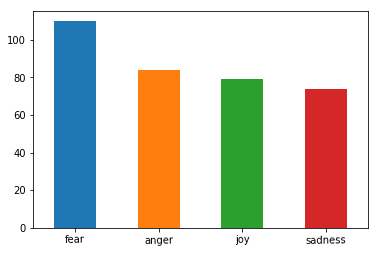

In [13]:
#plot the categories distribution for testing data
test_data.emotion.value_counts().plot(kind='bar', rot=1)

---
### Train Naive Models (Baselines)
- Bag of words
- N-grams
- TF-IDF

#### Bag of Words
Using scikit-learn CountVectorizer perform word frequency and use these as features to train a model.

In [14]:
# build analyzers
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 

# apply analyzer
train_data_features = count_vectorizer.fit_transform(train_data['text'])

In [16]:
# observe some features
count_vectorizer.get_feature_names()[100:110]

['af',
 'affair',
 'affliction',
 'afford',
 'afraid',
 'afternoon',
 'age',
 'agent',
 'ages',
 'aggravate']

In [15]:
train_data_features.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [16]:
train_data_features.shape

(3613, 3000)

In [37]:
logreg_model = linear_model.LogisticRegression() # max_iter 
logreg_model = logreg_model.fit(train_data_features, train_data['emotion'])

In [38]:
logreg_model.n_iter_

array([10], dtype=int32)

In [21]:
test_features = count_vectorizer.transform(test_data.text)
test_features[:10].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [22]:
model_predict = logreg_model.predict(test_features)
model_predict[:10]

array(['fear', 'fear', 'joy', 'joy', 'fear', 'sadness', 'fear', 'joy',
       'joy', 'anger'], dtype=object)

In [23]:
test_data.emotion.tolist()[:10]

['fear', 'sadness', 'joy', 'joy', 'fear', 'joy', 'joy', 'joy', 'joy', 'anger']

In [26]:
print(classification_report(test_data.emotion.tolist(), model_predict, my_tags))

             precision    recall  f1-score   support

    sadness       0.81      0.80      0.80        74
       fear       0.79      0.86      0.82       110
        joy       0.86      0.87      0.87        79
      anger       0.90      0.79      0.84        84

avg / total       0.84      0.83      0.83       347



accuracy 0.8328530259365994
             precision    recall  f1-score   support

    sadness       0.81      0.80      0.80        74
       fear       0.79      0.86      0.82       110
        joy       0.86      0.87      0.87        79
      anger       0.90      0.79      0.84        84

avg / total       0.84      0.83      0.83       347

(row=expected, col=predicted)


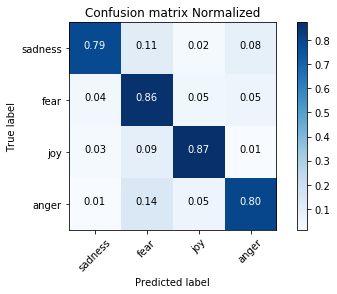

In [19]:
word_embeddings.predict(count_vectorizer, logreg_model, test_data, my_tags)

In [28]:
# words for the emotion of anger
anger_tag_id = word_embeddings.get_tag_index(my_tags, "anger") 
anger_words,c = word_embeddings.most_influential_words(logreg_model, count_vectorizer, \
                                                      anger_tag_id, 3000)
anger_words = pd.DataFrame(anger_words)

In [29]:
# Please show the top 10 anger word
anger_words.head(10)

0         1
0       sober  3.388245
1       blues  3.245923
2        dark  3.194681
3  depressing  3.184098
4     unhappy  3.152059
5        pine  2.975962
6  depression  2.966100
7        grim  2.956276
8      stayed  2.948947
9        dull  2.893124

In [30]:
# words for the emotion of fear
fear_tag_id = word_embeddings.get_tag_index(my_tags, "fear") 
fear_words, _ = word_embeddings.most_influential_words(logreg_model, count_vectorizer, \
                                                      fear_tag_id, 3000)
fear_words = pd.DataFrame(fear_words)

In [31]:
# Please show the top 10 fear word
fear_words.head(10)

0         1
0  nightmare  2.957114
1  terrorism  2.797497
2      bully  2.757590
3     horror  2.705866
4    nervous  2.680477
5      panic  2.655063
6       fear  2.629024
7        shy  2.552384
8   horrific  2.547787
9   horrible  2.546453

In [32]:
# check overlap of words and their index
word_embeddings.check_word_overlap(anger_words[:500][0], fear_words[:500][0])

[[['dreadful', 30],
  ['idea', 141],
  ['rich', 225],
  ['room', 267],
  ['penny', 285],
  ['honestly', 312],
  ['bake', 401],
  ['starting', 403],
  ['amateurs', 407],
  ['going', 421]],
 10]

In [33]:
from matplotlib_venn import venn2

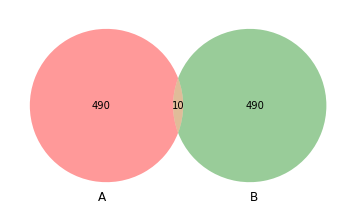

In [34]:
venn2([set(anger_words[:500][0].tolist()), set(fear_words[:500][0].tolist())])
plt.show()

You may notice that even though the words overlap some of them are not even related to any of the emotions, therefore, we can improve this model. What would happen if we just remove the overlapping words?

#### Character N-grams
A character n-gram is a chunk of a document of length n. It is a poor man's tokenizer but sometimes works well. The parameter n depends on language and the corpus. We choose length between 3 and 6 characters and to only focus on 3k most popular ones. 3K is a fair comparison since the previous bag of words model was this size as well.

In [39]:
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

charn_model = linear_model.LogisticRegression()

train_data_features = n_gram_vectorizer.fit_transform(train_data['text'])

charn_model = charn_model.fit(train_data_features, train_data['emotion'])

In [40]:
### observe some features
n_gram_vectorizer.get_feature_names()[100:110]

[' bec',
 ' beca',
 ' bee',
 ' been',
 ' bei',
 ' bein',
 ' bet',
 ' bi',
 ' bl',
 ' bla']

accuracy 0.6685878962536023
             precision    recall  f1-score   support

    sadness       0.62      0.72      0.66        74
       fear       0.69      0.67      0.68       110
        joy       0.74      0.61      0.67        79
      anger       0.65      0.68      0.66        84

avg / total       0.67      0.67      0.67       347

(row=expected, col=predicted)


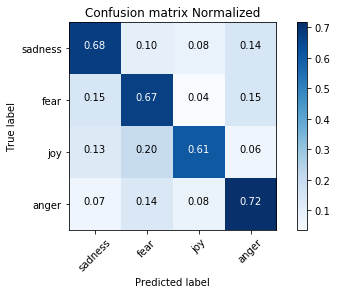

In [41]:
word_embeddings.predict(n_gram_vectorizer, charn_model, test_data, my_tags)

You can notice that the char n-gram model doesn't perform as well as the bag of words model.

**Exercise:** Try to improve the model by removing stopwords; or try other techniques you have learned so far.

In [42]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tcfst\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [43]:
stops = stopwords.words("english")
stops[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [44]:
### TRY

#### TF-IDF
Term Frequency - Inverse Document Frequency is useful to rank importance of words to documents

In [49]:
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['text'])

tfidf_model = linear_model.LogisticRegression()
tfidf_model = tfidf_model.fit(train_data_features, train_data['emotion'])

In [50]:
tf_vect.get_feature_names()[100:110]

['17',
 '18:41',
 '1nataliemaines',
 '1st',
 '2',
 '2-3',
 '20',
 '2014',
 '2015.',
 '2016']

In [51]:
len(tf_vect.get_feature_names())

4461

accuracy 0.8328530259365994
             precision    recall  f1-score   support

    sadness       0.84      0.78      0.81        74
       fear       0.76      0.90      0.82       110
        joy       0.88      0.85      0.86        79
      anger       0.92      0.77      0.84        84

avg / total       0.84      0.83      0.83       347

(row=expected, col=predicted)


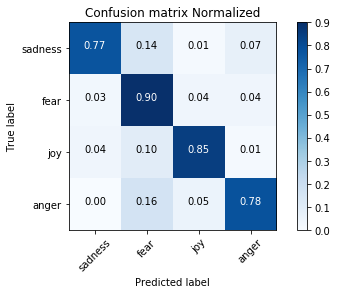

In [52]:
word_embeddings.predict(tf_vect, tfidf_model, test_data, my_tags)

Let us perform some further analysis on the TF-IDF model.

In [53]:
# words for the anger emotion
anger_tag_id = word_embeddings.get_tag_index(my_tags, "anger")
anger_words,_ = word_embeddings.most_influential_words(tfidf_model, tf_vect, anger_tag_id, 3000)
anger_words[0:10]

[['lost', 4.51149161990039],
 ['sober', 4.012762033346432],
 ['unhappy', 3.8954486855537733],
 ['blues', 3.8883941192681024],
 ['sad', 3.877067465595683],
 ['depression', 3.851530051647837],
 ['dark', 3.702773568225728],
 ['depressing', 3.6598840448946226],
 ['grim', 3.483440401126533],
 ['sadness', 3.200462778367911]]

In [54]:
# words for the joy
joy_tag_id = word_embeddings.get_tag_index(my_tags, "joy")
joy_words,_ = word_embeddings.most_influential_words(tfidf_model, tf_vect, joy_tag_id, 3000)
joy_words[0:10]

[['happy', 4.156835512100191],
 ['hilarious', 4.136882239558456],
 ['optimism', 4.068416654473182],
 ['glee', 3.7908770939424326],
 ['smile', 3.7361073851292668],
 ['elated', 3.2597119315978698],
 ['lively', 3.217856681469899],
 ['cheering', 3.206627517355833],
 ['laughter', 3.09952460543483],
 ['animated', 3.014717990010882]]

**Exercise:** Head to scikit-learn webiste and learn how to use different parameters for the TF-IDF vectorizer, such as modifying the ngram_range. It might improve the performance of the classifier.

---

### Averaging Word Vectors (word2vec model)

**SOURCE:** https://code.google.com/archive/p/word2vec/

First, we are going to use a pretrained model provided as open source by Google (word2vec)

In [55]:
%%time

wv = gensim.models.KeyedVectors.load_word2vec_format(
    "data/word2vec/GoogleNews-vectors-negative300.bin.gz",
    binary=True)
wv.init_sims(replace=True)

2018-06-01 14:57:02,603 : INFO : loading projection weights from data/word2vec/GoogleNews-vectors-negative300.bin.gz
2018-06-01 14:58:48,174 : INFO : loaded (3000000, 300) matrix from data/word2vec/GoogleNews-vectors-negative300.bin.gz
2018-06-01 14:58:48,174 : INFO : precomputing L2-norms of word weight vectors


Wall time: 2min 7s


**Pre-processing** Here we tokenize both the training and testing datasets before creating the vectors with word2vec. Think of this as a filtering step. In this case words with len(word)<2 are removed.

In [57]:
test_tokenized = test_data.apply(lambda r: word2vec_helpers.w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train_data.apply(lambda r: word2vec_helpers.w2v_tokenize_text(r['text']), axis=1).values

In [58]:
test_tokenized[0:10]

array([list(['Hillary', 'Clinton', 'looked', 'the', 'other', 'way', 'to', 'the', 'Saudi', 'war', 'on', 'women', 'and', 'their', 'terror', 'financing', 'because', 'they', 'bought', 'her', 'off']),
       list(['This', 'world', 'has', 'some', 'serious', 'issues', 'we', 'should', 'all', 'go', 'to', 'therapy']),
       list(['How', 'can', 'rule', 'my', 'mind', '\\nIt', "'s", 'hilarious', 'that', 'you', 'ca', "n't", '😭😑😮']),
       list(['bruins_514', 'gorddownie', 'thehipdotcom', 'It', 'would', 'be', 'TragicallyHip', 'if', 'they', 'can', 'help', 'TOYSFORASMILE', 'make', 'hospitalized', 'sick', 'kids', 'smile', '😊✌❤']),
       list(['They', "'ll", 'be', 'yo', 'friend', 'shake', 'your', 'hand', 'then', 'kick', 'in', 'yo', 'door', 'thas', 'the', 'way', 'the', 'game', 'go🤖🤐']),
       list(['Dolores', 'thin', 'lipped', 'smile', 'graced', 'glossed', 'lips', 'as', 'she', 'let', 'blues', 'peer', 'over', 'at', 'the', 'woman', 'constant', 'delight..', 'As', 'always']),
       list(['Nawaz', 'Sharif

Next, we have to convert the words into a distributed representation (in other words, each token must be converted into its vector representation obtained from word2vec). Since we are using a pretrained word2vec the conversion can be done easily. 

Now that we have the word embeddings, we can obtain vectors for an entire document, by averaging word vectors. (Warning: very naive approach!)

![alt txt](https://docs.google.com/drawings/d/1m1Uod7QU4iSN7J3iqsTU6JRWdGTEJRZ2dA7rZrgNHgA/pub?w=942&h=375)

In [59]:
### Here we average the word vectors
X_train_word_average = word2vec_helpers.word_averaging_list(wv,train_tokenized)
X_test_word_average = word2vec_helpers.word_averaging_list(wv,test_tokenized)

In [61]:
X_train_word_average[0].shape

(300,)

**Further exploration of word2vec generated vectors**

Some tips here: https://radimrehurek.com/gensim/models/keyedvectors.html

In [64]:
### obtain vector for a specific word
wv['unhappy']

array([ 7.44407773e-02,  5.99248260e-02, -1.14452699e-02, -9.60286036e-02,
       -6.58800900e-02,  8.22570622e-02,  3.55454721e-02, -1.34923914e-02,
        6.36468679e-02,  9.82618257e-02, -4.52227741e-02, -9.44467355e-03,
       -3.59176770e-02,  4.80143018e-02, -3.16373296e-02,  5.06197289e-02,
        7.18353540e-02,  1.92615520e-02,  2.38210484e-02, -8.88636801e-03,
       -2.18669791e-02,  8.93289372e-02,  1.46090025e-02,  1.07008619e-02,
        1.19105242e-01,  4.76420969e-02,  7.58365449e-03,  1.37715442e-02,
        9.04455483e-02, -5.84360100e-02,  6.21580519e-02, -3.23817395e-02,
        5.54583818e-02,  9.49119963e-03,  1.11661166e-01, -8.33736733e-02,
        9.67730135e-02,  3.25678401e-02, -3.85231040e-02,  4.24312428e-02,
        3.77786942e-02, -1.43298497e-02, -7.67670525e-03, -8.52346942e-02,
       -5.21085449e-02, -1.04961500e-01, -4.42922637e-02,  3.59176770e-02,
       -7.22075552e-02, -5.95526211e-03, -7.36963674e-02, -1.39576457e-02,
       -2.73569860e-02, -

Other fun operations you can do with word2vec model

In [62]:
wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431607246399),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]

In [63]:
wv.most_similar(positive=['GOP', 'Trump'], negative=['money'])

[('Republican', 0.5712672472000122),
 ('Republicans', 0.5465080738067627),
 ('Donald_Trump', 0.5382609367370605),
 ('Gingrich', 0.5238125920295715),
 ('Palin', 0.5126574039459229),
 ('Santorum', 0.4977916479110718),
 ('Dems', 0.49728360772132874),
 ('Democratic', 0.49602845311164856),
 ('GOPers', 0.4934149980545044),
 ('Democrats', 0.4912266731262207)]

**Exercise:** Try to research mode about the intuition behind these operations and try to come up with more interesting ones.

For fun, let us try to manually compute the cosine similarity of some of our word vectors, which is computed as follows:

![alt txt](https://docs.google.com/drawings/d/1QI_5_uxopOYgk2PzU_RMTUGKkoNhJp81aIz4SUwsHIM/pub?w=956&h=263)

In [64]:
word_embeddings.cosine_measure(wv['gun'], wv['pistol'])

0.7692407558643691

**Exercise:** Try to find cosine similarity between emotion related words. 

In [65]:
####
word_embeddings.cosine_measure(wv['dog'], wv['book'])

0.08555608504995733

In [66]:
word_embeddings.cosine_measure(wv['dog'], wv['tiger'])

0.4395674085383773

---

### KNN Classification

Now we train a KNN and a logistic regression classifier and observe how they perfom on these word-averaging document features

Read about KNN- https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

![alt txt](https://docs.google.com/drawings/d/13xu1RP3pVem277_eT900af7iz_MvTQUrLoxzWAewb_o/pub?w=817&h=614)

In [67]:
### train model
knn_naive_dv = KNeighborsClassifier(n_neighbors=10, n_jobs=-1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.emotion)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='cosine',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='uniform')

In [68]:
### obtain predictions on test data
predicted = knn_naive_dv.predict(X_test_word_average)

accuracy 0.4755043227665706
             precision    recall  f1-score   support

    sadness       0.44      0.42      0.43        74
       fear       0.54      0.56      0.55       110
        joy       0.46      0.43      0.44        79
      anger       0.43      0.45      0.44        84

avg / total       0.47      0.48      0.47       347

(row=expected, col=predicted)


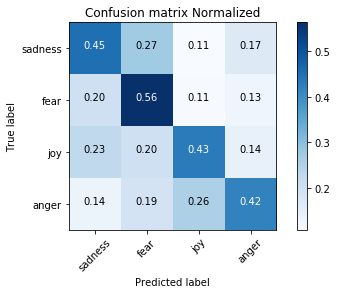

In [69]:
### evaluate the model
word_embeddings.evaluate_prediction(predicted, test_data.emotion, my_tags)

In [ ]:
### Try a best result

You can see that K-Neareset Neighbour doesn't perform well when using the average vector representations (obtained from pretrained word2vec) of the text data. This is partly because the pretrained word2vec may not be helping with the task at hand. What if we train our own word2vec using our dataset? (We need a lot of data!)

In [74]:
test_data.iloc()[56]['text']

'incredible that anthony weiner has been caught chasing a busty milkmaid across a park at double speed while jaunty music plays'

In [75]:
wv.most_similar(positive=[X_test_word_average[56]], restrict_vocab=100000, topn=30)[0:20]

[('just', 0.5738069415092468),
 ('but', 0.4927141070365906),
 ('anyway', 0.48917579650878906),
 ('then', 0.4796845316886902),
 ('really', 0.47954824566841125),
 ('actually', 0.4737807810306549),
 ('By_TBT_staff', 0.4705744981765747),
 ('around', 0.4660603404045105),
 ('so', 0.45868638157844543),
 ('crazy', 0.45673203468322754),
 ('You_EIG', 0.45534127950668335),
 ("'ve", 0.45004165172576904),
 ('By_Anonymous_##-##-##', 0.4481762647628784),
 ('maybe', 0.44582027196884155),
 ('like', 0.4442966878414154),
 ('when', 0.4438467025756836),
 ('that', 0.4435027539730072),
 ('always', 0.44124850630760193),
 ('loves', 0.43922510743141174),
 ('got', 0.4383433163166046)]

The problem with the result is that the average of this particular document falls under some area that is not related to the overall emotion portrayed by the original document.

**Exercise:** Try to remove stopwords. Try to figure out how you would achieve this using the current implementation of the *w2v_tokenize_text* function. Also, report the accuracy you achieved.

**Exercise:** Head on over to the Gensim website and figure out how to train a wordvec on your own using the gensim library. 

---

### Doc2Vec
Paper: https://cs.stanford.edu/~quocle/paragraph_vector.pdf
It is a **semi-supervised** approach since a **weak label or tag** (you can put many) is introduced into training documents before modeling. Read more about semi-supervised appraoches here: https://en.wikipedia.org/wiki/Semi-supervised_learning

![alt txt](https://docs.google.com/drawings/d/1TT6jNhk8rVoWMQajb8AIXCtyug0t_YVVZrvFidDPUPU/pub?w=679&h=375)

In [78]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [79]:
### First we tag each text with its emotion
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=word_embeddings.tokenize_text(r['text']), tags=[r.emotion]), axis=1)

In [81]:
train_tagged.head(4)

641    ([you, are, an, angry, glass, of, vodka], [ang...
609    ([merenthaprophet, the, hunter, in, this, way,...
689          ([my, wasp, sting, is, so, itchy], [anger])
219    ([theshadeshit91, \noh, 'm, sorry, about, it, ...
dtype: object

In [80]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=word_embeddings.tokenize_text(r['text']), tags=[r.emotion]), axis=1)

In [84]:
test_tagged.values[2]

TaggedDocument(words=['was', 'so', 'embarrassed', 'when', 'she', 'saw', 'us', 'was', 'like', 'knvfkkjg', 'she', 'thinks', 'we', "'re", 'stalkers', 'then', 'she', 'starts', 'waving', 'all', 'cheerfully', 'inviting', 'us', 'in'], tags=['joy'])

In [85]:
# transform into proper format
trainsent = train_tagged.values
testsent = test_tagged.values

In [86]:
trainsent

array([TaggedDocument(words=['you', 'are', 'an', 'angry', 'glass', 'of', 'vodka'], tags=['anger']),
       TaggedDocument(words=['merenthaprophet', 'the', 'hunter', 'in', 'this', 'way', 'content', 'and', 'joyous', 'in', 'simple', 'domestic', 'bliss', 'can', 'not', 'wait', 'for', 'word', 'of', 'who', 'you', 'truly', 'are', 'to'], tags=['joy']),
       TaggedDocument(words=['my', 'wasp', 'sting', 'is', 'so', 'itchy'], tags=['anger']),
       ...,
       TaggedDocument(words=['worst', 'juror', 'ever', 'michelle', 'you', 'were', 'nicole', "'s", 'biggest', 'threat', 'bitter', 'bb18'], tags=['anger']),
       TaggedDocument(words=['katiewhiskey_', 'bradnarok', 'candy', 'corn', 'is', 'the', 'greatest', 'candy', 'in', 'the', 'world', 'when', 'it', 'comes', 'to', 'being', 'objectively', 'terrible'], tags=['fear']),
       TaggedDocument(words=['today', 'has', 'dragged', 'on'], tags=['fear'])],
      dtype=object)

In [132]:
# train the model with simple gensim doc2vec api
# size (dimensions of features)
# dm is the training algorithm (distribute memory (1) or distributed bag of words)
doc2vec_model = Doc2Vec(trainsent, workers=4, size=200, iter=25, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

/home/yenhao/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:362: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/home/yenhao/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
2018-05-30 18:14:15,807 : INFO : collecting all words and their counts
2018-05-30 18:14:15,808 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2018-05-30 18:14:15,835 : INFO : collected 10719 word types and 4 unique tags from a corpus of 3613 examples and 56393 words
2018-05-30 18:14:15,836 : INFO : Loading a fresh vocabulary
2018-05-30 18:14:15,841 : INFO : min_count=5 retains 1361 unique wor

2018-05-30 18:14:18,370 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-30 18:14:18,401 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-30 18:14:18,411 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-30 18:14:18,411 : INFO : EPOCH - 14 : training on 56393 raw words (34975 effective words) took 0.2s, 220905 effective words/s
2018-05-30 18:14:18,537 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-05-30 18:14:18,541 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-30 18:14:18,567 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-30 18:14:18,584 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-30 18:14:18,584 : INFO : EPOCH - 15 : training on 56393 raw words (34942 effective words) took 0.2s, 210055 effective words/s
2018-05-30 18:14:18,741 : INFO : worker thread finished; awaiting finish of 3 more threads
2018

In [133]:
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

Let us see what our data looks like after training and transormations

In [134]:
test_targets[0:5]

('fear', 'anger', 'joy', 'joy', 'fear')

In [135]:
test_regressors[0:2]

(array([-0.0583692 ,  0.03254427, -0.01126137,  0.0079791 , -0.00333117,
         0.04295346,  0.06649154, -0.01703322,  0.00834214,  0.01096944,
         0.00303793, -0.02326575,  0.00022128,  0.02237617,  0.0214873 ,
         0.00894236,  0.0117696 , -0.00982242,  0.02814161,  0.02552819,
        -0.09044892, -0.00170861,  0.05974961, -0.00192251, -0.00282062,
        -0.03928155,  0.02396453,  0.02086362,  0.00944546, -0.05529038,
        -0.01437261,  0.07062367, -0.00026664, -0.04564705, -0.02291014,
        -0.02400522,  0.00128322, -0.07463649, -0.0292448 , -0.04209425,
         0.00559817,  0.02607793,  0.01573071,  0.0222479 , -0.03092894,
        -0.02214423,  0.01327   ,  0.05260582,  0.00515129, -0.02383633,
        -0.04084218, -0.02450549, -0.00026785,  0.03237607, -0.01228325,
         0.02740297, -0.05379428,  0.01364476, -0.07683898,  0.03343469,
         0.05533188,  0.04040706,  0.01746913, -0.00317712, -0.00785458,
        -0.02443975, -0.00406757,  0.03738292,  0.0

In [136]:
# train a logistic regression model
d2v_model = linear_model.LogisticRegression()
d2v_model = d2v_model.fit(train_regressors, train_targets)

accuracy 0.6657060518731989
             precision    recall  f1-score   support

    sadness       0.64      0.50      0.56        74
       fear       0.65      0.79      0.71       110
        joy       0.65      0.70      0.67        79
      anger       0.74      0.62      0.68        84

avg / total       0.67      0.67      0.66       347

(row=expected, col=predicted)


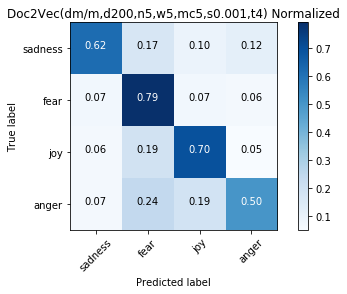

In [143]:
word_embeddings.evaluate_prediction(d2v_model.predict(test_regressors), test_targets, my_tags,title=str(doc2vec_model))

Now let us train KNN model with doc2vec.

2018-05-30 18:10:59,410 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.654178674351585
             precision    recall  f1-score   support

    sadness       0.61      0.55      0.58        74
       fear       0.72      0.66      0.69       110
        joy       0.57      0.78      0.66        79
      anger       0.74      0.61      0.67        84

avg / total       0.67      0.65      0.65       347

(row=expected, col=predicted)


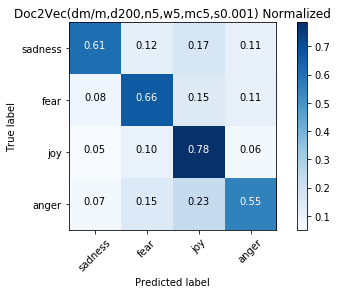

In [125]:
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
word_embeddings.evaluate_prediction(knn_test_predictions, test_targets,my_tags, str(doc2vec_model))

Since doc2vec also gives us a vector for each genre, we can also observe which genres are similar to each other

In [126]:
doc2vec_model.docvecs.most_similar('anger')

[('sadness', 0.1748349964618683),
 ('fear', 0.16330456733703613),
 ('joy', 0.13538245856761932)]

In [127]:
doc2vec_model.docvecs.most_similar('fear')

[('sadness', 0.19061167538166046),
 ('joy', 0.17252500355243683),
 ('anger', 0.16330456733703613)]

Since words and categories fall in the same vector space, it is possible to also observe which words sorround a tag. Notice how well those words describe the tag.

In [128]:
doc2vec_model.most_similar([doc2vec_model.docvecs['joy']])

/home/yenhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2018-05-30 18:11:11,618 : INFO : precomputing L2-norms of word weight vectors


[('strength', 0.9711489081382751),
 ('beautiful', 0.9496297836303711),
 ('gloomy', 0.945300817489624),
 ('thenicebot', 0.9421520233154297),
 ('determined', 0.9413958787918091),
 ('artist', 0.9349844455718994),
 ('quote', 0.9260014295578003),
 ('block', 0.9226003885269165),
 ('radio', 0.9160070419311523),
 ('red', 0.9125329852104187)]

### Visualization
We will visualize embeddings using a popular algorithm called T-SNE, which is very similar to the dimentionality reduction algorithm called PCA.

In [142]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [130]:
### unpacking words from the dco2vec model trained
doc2vec_words = word2vec_helpers.unpack_words_from_doc_vector(doc2vec_model)

**Exercise:** Try to visualize words and find interesting clusters. There are so many creative ways to visualize these powerful vector representations. You can also try other type of classifiers and apply other improvements in the preprocessing stages.

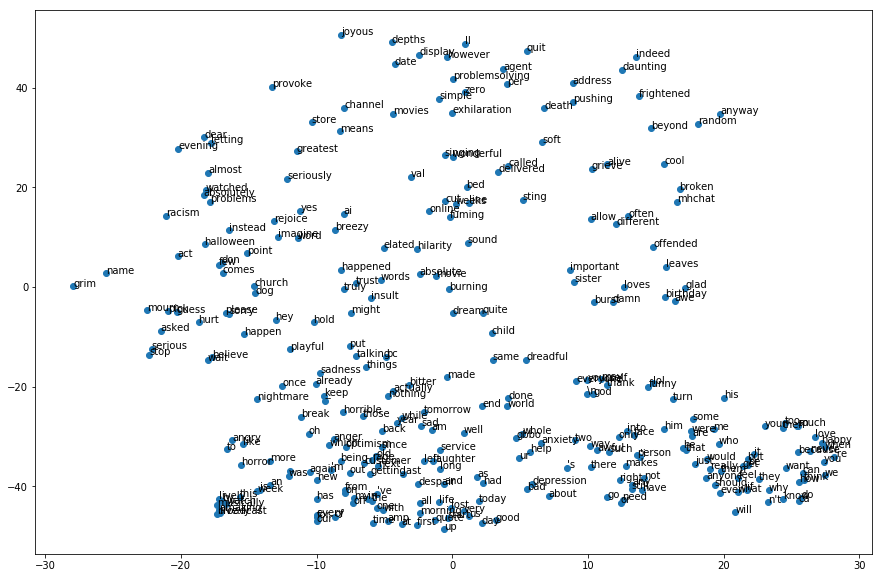

In [131]:
word2vec_helpers.visualize_vectors(doc2vec_model, doc2vec_words)

## Clustering

In [70]:
from sklearn import cluster

### K-means

In [71]:
kmean_cluster = cluster.KMeans(n_clusters = 4) # 4 emotion

#### bow cluster

In [72]:
kmeans_fit_bow = kmean_cluster.fit(train_data_features)

In [73]:
# Clustering Result
cluster_labels_bow = kmeans_fit_bow.labels_
cluster_labels_bow[:20]

array([0, 0, 1, 0, 3, 1, 0, 2, 0, 0, 2, 1, 1, 3, 3, 1, 0, 2, 1, 0])

Try again! What do you see?!

In [74]:

kmeans_fit_bow = kmean_cluster.fit(train_data_features)
cluster_labels_bow = kmeans_fit_bow.labels_
cluster_labels_bow[:20]

array([0, 0, 3, 0, 1, 3, 0, 2, 0, 0, 2, 3, 3, 1, 1, 3, 0, 2, 3, 0])

#### convert categories to number

In [75]:
train_data.emotion = pd.Categorical(train_data.emotion)
train_data['emotion_label'] = train_data.emotion.cat.codes
train_data['emotion_label'].tolist()[:20]

[1, 2, 2, 3, 0, 0, 1, 0, 3, 3, 3, 3, 0, 1, 2, 3, 3, 2, 0, 3]

In [76]:
from sklearn.decomposition import PCA

In [77]:
X_reduced = PCA(n_components=2).fit_transform(train_data_features.toarray())

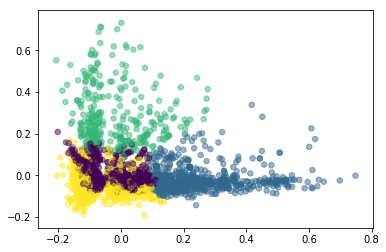

In [78]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels_bow, s=30, alpha=0.5, cmap='viridis')

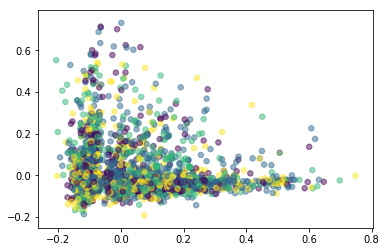

In [79]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=train_data['emotion_label'].tolist(), s=30, alpha=0.5, cmap='viridis')

In [80]:
from mpl_toolkits.mplot3d import Axes3D

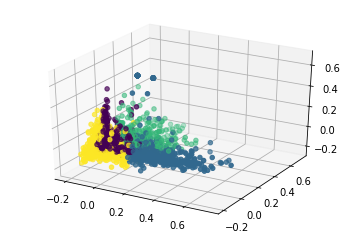

In [81]:
X_reduced = PCA(n_components=3).fit_transform(train_data_features.toarray())
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=cluster_labels_bow, cmap='viridis')
plt.show()
plt.close()

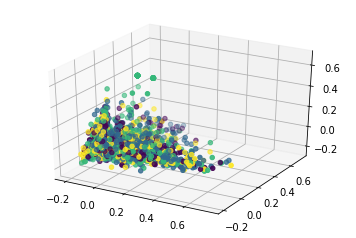

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=train_data['emotion_label'].tolist(), cmap='viridis')
plt.show()
plt.close()

#### Word2vec cluster

In [83]:
kmeans_fit_w2v = kmean_cluster.fit(X_train_word_average)
# Clustering Result
cluster_labels_w2v = kmeans_fit_w2v.labels_
cluster_labels_w2v[:20]

array([1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 0, 1, 2, 3, 2, 2, 1, 1, 2])

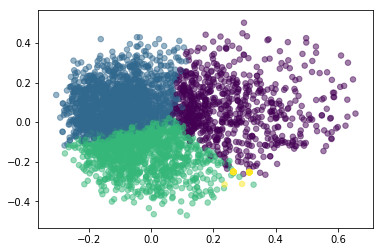

In [84]:
### Please draw the scatter for word2vec and predict label
X_reduced = PCA(n_components=2).fit_transform(X_train_word_average)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels_w2v, s=30, alpha=0.5, cmap='viridis')

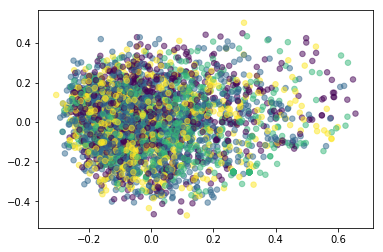

In [86]:
# please show the scatter for emotion label
X_reduced = PCA(n_components=2).fit_transform(X_train_word_average)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=train_data['emotion_label'].tolist(), s=30, alpha=0.5, cmap='viridis')

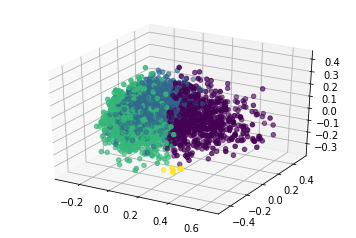

In [89]:
# Plot both graph for 3d with clustering label
X_reduced = PCA(n_components=3).fit_transform(X_train_word_average)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=cluster_labels_w2v, cmap='viridis')
plt.show()
plt.close()

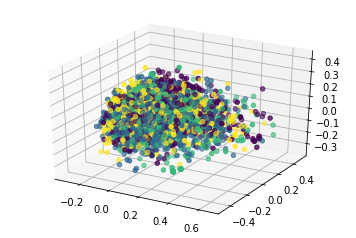

In [90]:
# Plot both graph for 3d with emotion label
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=train_data['emotion_label'].tolist(), cmap='viridis')
plt.show()
plt.close()

In [91]:
train_data.emotion.cat.categories

Index(['anger', 'fear', 'joy', 'sadness'], dtype='object')

In [92]:
import helpers.text_analysis as ta
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = ta.get_trace(X_reduced, train_data['emotion'], "anger", "rgb(71,233,163)")
trace2 = ta.get_trace(X_reduced, train_data['emotion'], "fear", "rgb(52,133,252)")
trace3 = ta.get_trace(X_reduced, train_data['emotion'], "joy", "rgb(229,65,136)")
trace4 = ta.get_trace(X_reduced, train_data['emotion'], "sadness", "rgb(99,151,68)")

data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple-3d-scatter')

### how to determine is it a good cluster

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). The best value is 1 and the worst value is -1.

In [93]:
# performance of bow cluster
silhouette_score(train_data_features, cluster_labels_bow)

0.010294629952784089

In [94]:
# performance of w2v cluster
silhouette_score(X_train_word_average, cluster_labels_w2v)

0.040249627

#### How many K?

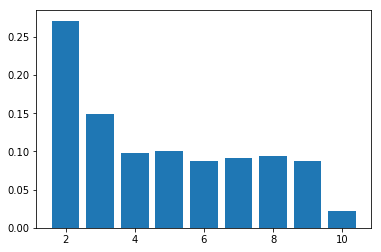

[0.27131818082331455, 0.14882356743471273, 0.09784185246188666, 0.10007936263017062, 0.08781678226888483, 0.09108035929802433, 0.09451837056902844, 0.08751693681770151, 0.02248153492238728]


In [208]:
silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k).fit(train_data_features.toarray())
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = silhouette_score(train_data_features.toarray(), cluster_labels)
    silhouette_avgs.append(silhouette_avg)


plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)

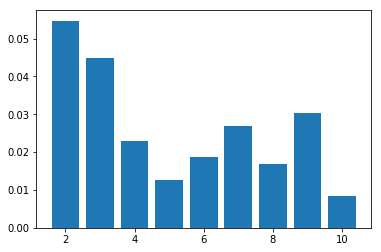

[0.054717693, 0.044824086, 0.022993786, 0.0125744585, 0.018797953, 0.02702118, 0.01681157, 0.030433498, 0.008349917]


In [98]:
### Please show what is the best K for word2vec
silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k).fit(X_test_word_average)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = silhouette_score(X_test_word_average, cluster_labels)
    silhouette_avgs.append(silhouette_avg)



plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)

#### Plot the clustering result with the best K

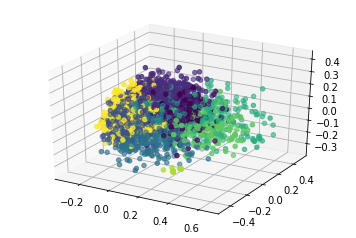

In [99]:
### YOUR CODE
kmean_cluster = cluster.KMeans(n_clusters = 9) # 4 emotion

kmeans_fit_w2v = kmean_cluster.fit(X_train_word_average)
# Clustering Result
cluster_labels_w2v = kmeans_fit_w2v.labels_
# cluster_labels_w2v[:20]

# Plot both graph for 3d with clustering label
X_reduced = PCA(n_components=3).fit_transform(X_train_word_average)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=cluster_labels_w2v, cmap='viridis')
plt.show()
plt.close()

### DBSCAN

Decide how many clusters itself

In [102]:
db_cluster = cluster.DBSCAN(eps=1, min_samples=2, n_jobs=4)
db_cluster_bow = db_cluster.fit(train_data_features.toarray())
# np.unique(db_cluster_w2v.labels_)
labels = db_cluster_bow.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 636


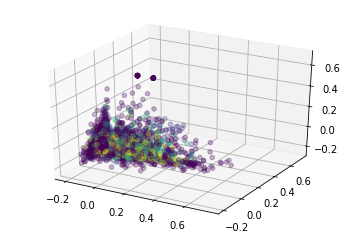

In [103]:
# Plot both graph for 3d ones
X_reduced = PCA(n_components=3).fit_transform(train_data_features.toarray())
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels, alpha=0.3, cmap='viridis')
plt.show()
plt.close()

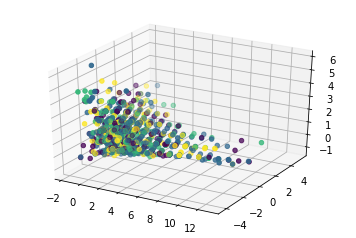

In [187]:
# Plot both graph for 3d with emotion label


In [195]:
db_cluster = cluster.DBSCAN(eps=0.5, min_samples=5)
db_cluster_w2v = db_cluster.fit(X_train_word_average)
# np.unique(db_cluster_w2v.labels_)
labels = db_cluster_w2v.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 3


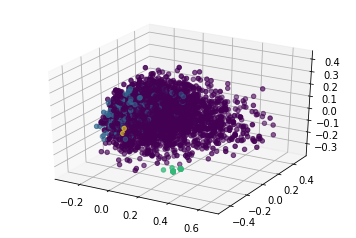

In [196]:
# Plot both graph for 3d ones
X_reduced = PCA(n_components=3).fit_transform(X_train_word_average)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels, cmap='viridis')
plt.show()
plt.close()

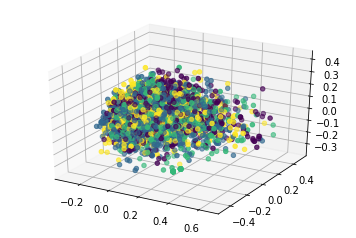

In [197]:
# Plot both graph for 3d ones
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=train_data['emotion_label'].tolist(), cmap='viridis')
plt.show()
plt.close()